In [ ]:
!pip install emoji==1.7.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171031 sha256=0475bb6804d83614485e2dcd5de2441d6c55bf929da82be4b81731456fe81116
  Stored in directory: /root/.cache/pip/wheels/31/8a/8c/315c9e5d7773f74b33d5ed33f075b49c6eaeb7cedbb86e2cf8
Successfully built emoji


In [ ]:
#general purpose packages
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

#data processing
import re, string
import emoji
import nltk

from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split


#Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

#Logistic Regression
from sklearn.linear_model import LogisticRegression

#KNN
from sklearn.neighbors import KNeighborsClassifier



#transformers
from transformers import BertTokenizerFast
from transformers import TFBertModel
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel

#keras
import tensorflow as tf
from tensorflow import keras

#metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

#set seed for reproducibility
seed=42

#set style for plots
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

<ipython-input-4-b6bc0180508f>:51: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


<Figure size 640x480 with 0 Axes>

In [ ]:
#Cutom function  for Confusion matrix
def conf_matrix(y, y_pred, title):
    fig, ax =plt.subplots(figsize=(5,5))
    labels=['Negative', 'Neutral', 'Positive']
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Blues", fmt='g', cbar=False, annot_kws={"size":25})
    plt.title(title, fontsize=20)
    ax.xaxis.set_ticklabels(labels, fontsize=17)
    ax.yaxis.set_ticklabels(labels, fontsize=17)
    ax.set_ylabel('Test', fontsize=20)
    ax.set_xlabel('Predicted', fontsize=20)
    plt.show()

In [ ]:
df=pd.read_csv('/content/Corona_NLP_train.csv', encoding='ISO-8859-1')

df_test = pd.read_csv('/content/Corona_NLP_test.csv')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# We convert the date column 'TweetAt' to pandas datetime format to improve its usability in the further analysis.
df['TweetAt'] = pd.to_datetime(df['TweetAt'])

<ipython-input-107-e18f03030e2b>:2: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['TweetAt'] = pd.to_datetime(df['TweetAt'])


In [ ]:
# Duplicate tweets
df.drop_duplicates(subset='OriginalTweet',inplace=True)

In [ ]:
# Tweets Deep Cleaning
df = df[['OriginalTweet','Sentiment']]
df_test = df_test[['OriginalTweet','Sentiment']]

In [ ]:
# Custom functions to clean the text of the tweets
#Clean emojis from text
def strip_emoji(text):
    return re.sub(emoji.get_emoji_regexp(), r"", text) #remove emoji

#Remove punctuations, links, mentions and \r\n new line characters
def strip_all_entities(text):
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

#Filter special characters such as & and $ present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

def remove_mult_spaces(text): # remove multiple spaces
    return re.sub("\s\s+" , " ", text)


In [ ]:
texts_new = []
for t in df.OriginalTweet:
    texts_new.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t))))))

<ipython-input-11-44773a8e9ce7>:4: DeprecationWarning: 'emoji.get_emoji_regexp()' is deprecated and will be removed in version 2.0.0. If you want to remove emoji from a string, consider the method emoji.replace_emoji(str, replace='').
To hide this warning, pin/downgrade the package to 'emoji~=1.6.3'
  return re.sub(emoji.get_emoji_regexp(), r"", text) #remove emoji


In [ ]:
texts_new_test = []
for t in df_test.OriginalTweet:
    texts_new_test.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t))))))

<ipython-input-11-44773a8e9ce7>:4: DeprecationWarning: 'emoji.get_emoji_regexp()' is deprecated and will be removed in version 2.0.0. If you want to remove emoji from a string, consider the method emoji.replace_emoji(str, replace='').
To hide this warning, pin/downgrade the package to 'emoji~=1.6.3'
  return re.sub(emoji.get_emoji_regexp(), r"", text) #remove emoji


In [ ]:
# Create a new column for both train and test tests, to host cleaned version of the tweets'text
df['text_clean'] = texts_new
df_test['text_clean'] = texts_new_test
df['text_clean'].head()
df_test['text_clean'].head()

,text_clean
0,trending new yorkers encounter empty supermark...
1,when i couldnt find hand sanitizer at fred mey...
2,find out how you can protect yourself and love...
3,panic buying hits newyork city as anxious shop...
4,toiletpaper dunnypaper coronavirus coronavirus...


In [ ]:
df['text_clean'][1:8].values

array(['advice talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist gp set up online shopping accounts if poss adequate supplies of regular meds but not over order',
       'coronavirus australia woolworths to give elderly disabled dedicated shopping hours amid covid19 outbreak',
       'my food stock is not the only one which is empty please dont panic there will be enough food for everyone if you do not take more than you need stay calm stay safe covid19france covid19 covid19 coronavirus confinement confinementotal confinementgeneral',
       'me ready to go at supermarket during the covid19 outbreak not because im paranoid but because my food stock is litteraly empty the coronavirus is a serious thing but please dont panic it causes shortage coronavirusfrance restezchezvous stayathome confinement',
       'as news of the regions first confirmed covid19 case came out of sullivan county last week people 

In [ ]:
#Create column to host the length of cleaned text, to check if by cleaning the text we removed too much text
text_len = []
for text in df.text_clean:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

text_len_test = []
for text in df_test.text_clean:
    tweet_len = len(text.split())
    text_len_test.append(tweet_len)

df['text_len'] = text_len
df_test['text_len'] = text_len_test

<ipython-input-17-e8163f7a3b22>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='text_len', data=df[df['text_len']<10], palette='mako')


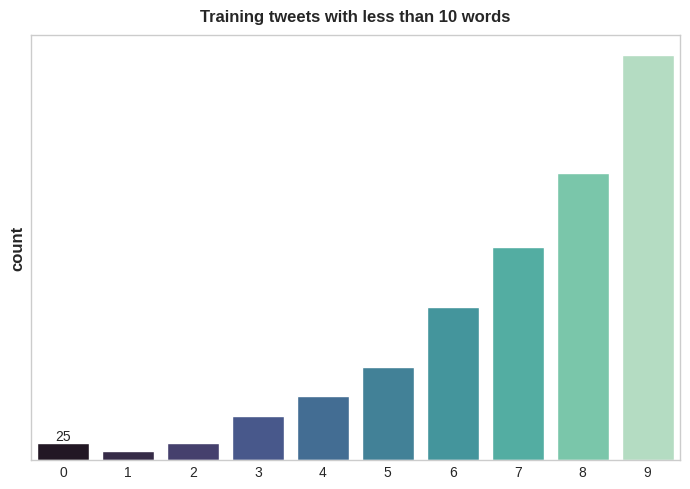

<ipython-input-17-e8163f7a3b22>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='text_len', data=df_test[df_test['text_len']<10], palette='mako')


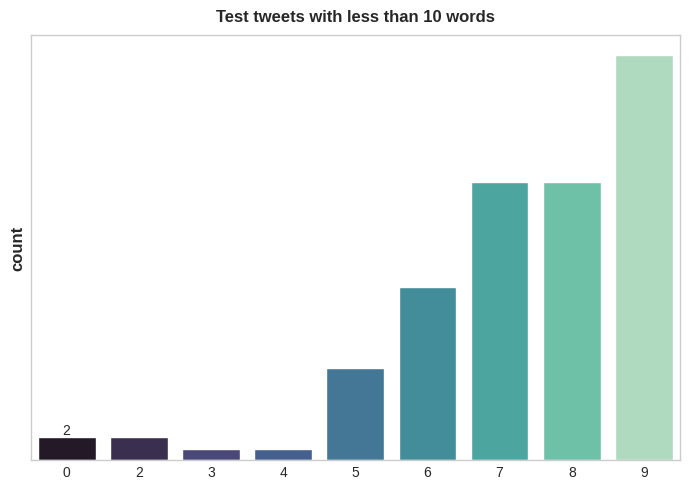

In [ ]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df[df['text_len']<10], palette='mako')
plt.title('Training tweets with less than 10 words')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df_test[df_test['text_len']<10], palette='mako')
plt.title('Test tweets with less than 10 words')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [ ]:
print(f" DF SHAPE: {df.shape}")
print(f" DF TEST SHAPE: {df_test.shape}")

 DF SHAPE: (41157, 4)
 DF TEST SHAPE: (3798, 4)


In [ ]:
df = df[df['text_len'] > 4]
df_test = df_test[df_test['text_len'] > 4]
print(f" DF SHAPE: {df.shape}")
print(f" DF TEST SHAPE: {df_test.shape}")

 DF SHAPE: (40935, 4)
 DF TEST SHAPE: (3792, 4)


## Training data deeper cleaning

In [ ]:
# BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
token_lens = []

for txt in df['text_clean'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))

max_len=np.max(token_lens)
print(f"MAX TOKENIZED SENTENCE LENGTH: {max_len}")

MAX TOKENIZED SENTENCE LENGTH: 100


In [ ]:
token_lens = []

for i,txt in enumerate(df['text_clean'].values):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
    if len(tokens)>80:
        print(f"INDEX: {i}, TEXT: {txt}")

INDEX: 1622, TEXT: zsah policie proti spekulantm s roukami na mj popud hejtman steckho kraje ve spoluprci s podle krizovho zkona zajistil tm 700 tisrouek od firmy kter je mla dodat na zdravotnkm ale na posledn chvli se snaila navyovat cenu spolutozvladneme
INDEX: 13623, TEXT: hoy aplaudo a mi segunda familia aplaudoanuestrosheroes aquellos con los que he compartido tantas noches de trabajo y tanta alegra s que como siempre dan todo por el bien de su comunidad presidente por ellos tambin cuarentenanacionalya cuidemosalosquecuidan
INDEX: 16548, TEXT: bir mddettir spermarketlerin lojistik hizmeti avusturya ordusu desteiyle yaplyor dn corona tedavisi iin 22 milyon luk bir aratrma gelitirme btesi aklad hkmet geen hafta da 35 milyon luk 2 yardm paketi aklanmt viyanadan haberler bu kadar
INDEX: 36953, TEXT: 11 nisan cumartesi itibariyle bbnin tm hizmetleri sokaa kma serbestisi olanlar iin devam edecek halk ekmek ve hamidiye su 100 retime geti bb tm stanbulun gda ihtiyacna yetecek kapasitededi

In [ ]:
df['token_lens'] = token_lens
df = df.sort_values(by='token_lens', ascending=False)
df.head(20)

,OriginalTweet,Sentiment,text_clean,text_len,token_lens
1638,ZÃ¡sah policie proti spekulant?m s rouÂkami. ...,Neutral,zsah policie proti spekulantm s roukami na mj ...,39,100
37156,11 Nisan Cumartesi itibariyle ?BBÂnin tÃ¼m hi...,Neutral,11 nisan cumartesi itibariyle bbnin tm hizmetl...,39,98
16632,Bir mÃ¼ddettir sÃ¼permarketlerin lojistik hizm...,Neutral,bir mddettir spermarketlerin lojistik hizmeti ...,36,92
13691,Hoy aplaudo a mi segunda familia #AplaudoANues...,Neutral,hoy aplaudo a mi segunda familia aplaudoanuest...,38,84
27005,Supermercados Econo confirman que un empleado ...,Neutral,supermercados econo confirman que un empleado ...,39,80
14593,"Na, wer war denn da am Werk? Gestern Nachmitta...",Extremely Negative,na wer war denn da am werk gestern nachmittag ...,37,80
28899,Kindly contact Us bamy global merchandise for ...,Positive,kindly contact us bamy global merchandise for ...,37,80
11213,Keine WertgegenstÃ¤nde im Fahrzeug lassen! - D...,Negative,keine wertgegenstnde im fahrzeug lassen diesen...,33,79
4844,Impct of #coronavirus i hve sen hw civilizd pp...,Extremely Negative,impct of coronavirus i hve sen hw civilizd ppl...,48,79
18913,#CroozefmNews \r\r\nPresident Museveni has ord...,Extremely Negative,croozefmnews president museveni has ordered th...,35,79


In [ ]:
df = df.iloc[12:]
df.head()

,OriginalTweet,Sentiment,text_clean,text_len,token_lens
12389,"Okay, so I just checked the drug prices for #P...",Positive,okay so i just checked the drug prices for pla...,35,77
1697,I work at a grocery store.\r\r\nWe wont get an...,Positive,i work at a grocery store we wont get any toil...,37,77
8730,?Bitte anschauen! (1/2)\r\r\n\r\r\nEmotionaler...,Negative,bitte anschauen 12 emotionaler aufruf von geha...,36,77
14582,hiked prices in the face of the Covid-19 crise...,Negative,hiked prices in the face of the covid19 crises...,47,77
36305,Sterile disposable anti bacterial wet wipes an...,Negative,sterile disposable anti bacterial wet wipes an...,31,76


In [ ]:
# Shuffle the data and reset the index
df = df.sample(frac=1).reset_index(drop=True)

## Test Deeper cleaning

In [ ]:
token_lens_test = []

for txt in df_test['text_clean'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens_test.append(len(tokens))

max_len=np.max(token_lens_test)

print(f"MAX TOKENIZED SENTENCE LENGTH: {max_len}")

token_lens_test = []

for i,txt in enumerate(df_test['text_clean'].values):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens_test.append(len(tokens))
    if len(tokens)>80:
        print(f"INDEX: {i}, TEXT: {txt}")

df_test['token_lens'] = token_lens_test

df_test = df_test.sort_values(by='token_lens', ascending=False)
df_test.head(10)

MAX TOKENIZED SENTENCE LENGTH: 96
INDEX: 286, TEXT: so hard to decide as much as i want to hodl my 2 ccdcv4 token our place is declared to lock down due to covid19 i will use this to buy some food to stock txnid093bd1db0c0d3a62af15883138a5f57d4cef35ae14e31e602b74489dd2524c7f my b
INDEX: 345, TEXT: informoval jsem zstupce vech obchodnch etzc o aktulnch opatench vldy etzce jsou zsobovny na 95 take nen dvod panikait zsoby potravin fakt nedojdou nen opravdu dvod dnes obsadit a vykoupit supermarkety
INDEX: 2380, TEXT: ahora seguid llorando por el papel higinico que no he comprado porque an tengo seguid creando histeria y preocupacin poniendo fotos de gente en pnico y estanteras vacas que yo seguir yendo a comercios responsables de barrio donde nos cuidan hoy y siempre gracias


,OriginalTweet,Sentiment,text_clean,text_len,token_lens
286,@Rhett800cc So hard to decide??. As much as I ...,Negative,so hard to decide as much as i want to hodl my...,38,96
2383,Ahora seguid llorando por el papel higiénico (...,Negative,ahora seguid llorando por el papel higinico qu...,44,94
345,Informoval jsem zástupce vech obchodních ?et?...,Neutral,informoval jsem zstupce vech obchodnch etzc o ...,31,86
1485,DTF-Dont Touch Face\r\r\nDWBH-Do Wash Both Ha...,Extremely Negative,dtfdont touch face dwbhdo wash both hands gtfo...,42,77
1209,Im in the DC/Maryland/Virginia (DMV) area &am...,Positive,im in the dcmarylandvirginia dmv area amphave ...,45,74
3505,Stop misusing ur privilege amp grow up Some1 c...,Positive,stop misusing ur privilege amp grow up some1 c...,57,73
1789,"For those that are cashlong, patient,calm&amp;...",Extremely Positive,for those that are cashlong patientcalmamphave...,44,71
855,"Lidl is total chaos, queues as long as the ais...",Extremely Negative,lidl is total chaos queues as long as the aisl...,62,70
2740,COVID-19: Your government will save ITSELF not...,Positive,covid19 your government will save itself not y...,43,70
2997,Stop #frenzybuying. You don't need most of wha...,Extremely Negative,stop frenzybuying you dont need most of what y...,38,70


In [ ]:
df_test = df_test.iloc[5:]
df_test.head(3)

,OriginalTweet,Sentiment,text_clean,text_len,token_lens
3505,Stop misusing ur privilege amp grow up Some1 c...,Positive,stop misusing ur privilege amp grow up some1 c...,57,73
1789,"For those that are cashlong, patient,calm&amp;...",Extremely Positive,for those that are cashlong patientcalmamphave...,44,71
855,"Lidl is total chaos, queues as long as the ais...",Extremely Negative,lidl is total chaos queues as long as the aisl...,62,70


In [ ]:
df_test = df_test.sample(frac=1).reset_index(drop=True)

## Sentiment column analysis

In [ ]:
df['Sentiment'].value_counts()

,count
Sentiment,
Positive,11381
Negative,9889
Neutral,7560
Extremely Positive,6618
Extremely Negative,5475


In [ ]:
# Create three possible emotions Positive, Neutral and Negative
df['Sentiment'] = df['Sentiment'].map({'Extremely Negative':0,'Negative':0,'Neutral':1,'Positive':2,'Extremely Positive':2})
df_test['Sentiment'] = df_test['Sentiment'].map({'Extremely Negative':0,'Negative':0,'Neutral':1,'Positive':2,'Extremely Positive':2})


In [ ]:
df['Sentiment'].value_counts()

,count
Sentiment,
2,17999
0,15364
1,7560


## Class Balancing by Randomoversampler

In [ ]:
ros = RandomOverSampler()
train_x, train_y = ros.fit_resample(np.array(df['text_clean']).reshape(-1, 1), np.array(df['Sentiment']).reshape(-1, 1));
train_os = pd.DataFrame(list(zip([x[0] for x in train_x], train_y)), columns = ['text_clean', 'Sentiment']);

In [ ]:
train_os['Sentiment'].value_counts()

,count
Sentiment,
0,17999
1,17999
2,17999


## Train-Valid_Test Split

In [ ]:
X = train_os['text_clean'].values
y = train_os['Sentiment'].values

In [ ]:
# Validation etracted from training set to monitor accuracy and prevent overfitting
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, stratify=y, random_state=seed)

In [ ]:
X_test = df_test['text_clean'].values
y_test = df_test['Sentiment'].values

## One hot encoding

In [ ]:
y_train_le = y_train.copy()
y_valid_le = y_valid.copy()
y_test_le = y_test.copy()

In [ ]:
one = preprocessing.OneHotEncoder()
y_train = one.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_valid = one.fit_transform(np.array(y_valid).reshape(-1, 1)).toarray()
y_test = one.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()

In [ ]:
print(f"TRAINING DATA: {X_train.shape[0]}\nVALIDATION DATA: {X_valid.shape[0]}\nTESTING DATA: {X_test.shape[0]}" )

TRAINING DATA: 48597
VALIDATION DATA: 5400
TESTING DATA: 3787


In [ ]:
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)

Shape of X_train: (48597,)
Shape of y_train: (48597, 3)


## Baseline models

In [ ]:
# We need ti tokenize the tweets using CountVectorizer
clf = CountVectorizer()
X_train_cv =  clf.fit_transform(X_train)
X_test_cv = clf.transform(X_test)

In [ ]:
#TF-IDF (term-frequency times inverse document-frequency) versions of the tokenized tweets.
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)
X_train_tf = tf_transformer.transform(X_train_cv)
X_test_tf = tf_transformer.transform(X_test_cv)

In [ ]:
nb_clf = MultinomialNB().fit(X_train_tf, y_train_le)
log_clf = LogisticRegression(random_state=seed).fit(X_train_tf, y_train_le)
knn_clf = KNeighborsClassifier(n_neighbors=5).fit(X_train_tf, y_train_le)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
nb_pred = nb_clf.predict(X_test_tf)
log_pred = log_clf.predict(X_test_tf)
knn_pred = knn_clf.predict(X_test_tf)

In [ ]:

print('\tClassification Report for Naive Bayes:\n\n',classification_report(y_test_le,nb_pred, target_names=['Negative', 'Neutral', 'Positive']))
print('\tClassification Report for Logistic Regression:\n\n',classification_report(y_test_le,log_pred, target_names=['Negative', 'Neutral', 'Positive']))
print('\tClassification Report for KNN:\n\n',classification_report(y_test_le,knn_pred, target_names=['Negative', 'Neutral', 'Positive']))


	Classification Report for Naive Bayes:

               precision    recall  f1-score   support

    Negative       0.70      0.78      0.74      1629
     Neutral       0.58      0.43      0.50       614
    Positive       0.74      0.72      0.73      1544

    accuracy                           0.70      3787
   macro avg       0.67      0.65      0.66      3787
weighted avg       0.70      0.70      0.70      3787

	Classification Report for Logistic Regression:

               precision    recall  f1-score   support

    Negative       0.82      0.78      0.80      1629
     Neutral       0.60      0.76      0.67       614
    Positive       0.83      0.79      0.81      1544

    accuracy                           0.78      3787
   macro avg       0.75      0.78      0.76      3787
weighted avg       0.79      0.78      0.78      3787

	Classification Report for KNN:

               precision    recall  f1-score   support

    Negative       0.61      0.49      0.54      1629
   

In [ ]:
# Accuracy for each model
print('\tAccuracy for Naive Bayes:',accuracy_score(y_test_le,nb_pred))
print('\tAccuracy for Logistic Regression:',accuracy_score(y_test_le,log_pred))
print('\tAccuracy for KNN:',accuracy_score(y_test_le,knn_pred))


	Accuracy for Naive Bayes: 0.7016107736994983
	Accuracy for Logistic Regression: 0.7784526010034328
	Accuracy for KNN: 0.46105096382360705


In [ ]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(text_clean):
    st = ""
    for w in w_tokenizer.tokenize(text_clean):
        st = st + lemmatizer.lemmatize(w) + " "
    return st
df['text_clean'] =df.text_clean.apply(lemmatize_text)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')
df['text_clean'] = df['text_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df

,OriginalTweet,Sentiment,text_clean,text_len,token_lens
0,"@NYGovCuomo Puzzles, coloring books, X box gam...",0,puzzle coloring book x box game watching news ...,26,30
1,Find out about how brands are turning over the...,1,find brand turning physical space help fight c...,39,45
2,Under-reported News frm Inside #Iran: The aid...,2,underreported news frm inside iran aid provide...,36,56
3,Thank you to @VoltaireDesUK who are proudly su...,2,thank proudly supporting year equestrianrelief...,21,32
4,My first day out in 8 days! Trip to the superm...,1,first day 8 day trip supermarket day8oflockdow...,15,31
...,...,...,...,...,...
40918,Queues outside a supermarket during times rese...,2,queue outside supermarket time reserved elderl...,16,21
40919,#JCPenney Temporarily Closes Stores and Busine...,1,jcpenney temporarily close store business offi...,18,28
40920,During our episode with @jfccohen Jake says th...,1,episode jake say one way look 2020 spending ma...,41,48
40921,Just read a post encouraging people to ingest ...,2,read post encouraging people ingest colloidal ...,35,51


In [ ]:
# prompt: chnage the 0, 1 and 2 to negative, neutral and positive

df['Sentiment'] = df['Sentiment'].map({0:'Negative', 1:'Neutral', 2:'Positive'})
df_test['Sentiment'] = df_test['Sentiment'].map({0:'Negative', 1:'Neutral', 2:'Positive'})

df.head(10)


,OriginalTweet,Sentiment,text_clean,text_len,token_lens
0,"@NYGovCuomo Puzzles, coloring books, X box gam...",NaN,puzzle coloring book x box game watching news ...,26,30
1,Find out about how brands are turning over the...,NaN,find brand turning physical space help fight c...,39,45
2,Under-reported News frm Inside #Iran: The aid...,NaN,underreported news frm inside iran aid provide...,36,56
3,Thank you to @VoltaireDesUK who are proudly su...,NaN,thank proudly supporting year equestrianrelief...,21,32
4,My first day out in 8 days! Trip to the superm...,NaN,first day 8 day trip supermarket day8oflockdow...,15,31
5,Very timely information from @FTC about #coron...,NaN,timely information coronavirus scam,7,11
6,@catturd2 @Styx666Official absolutely take the...,NaN,absolutely take coronavirus seriously dont pan...,37,42
7,"Also, masks and sanitisers are now sold only o...",NaN,also mask sanitisers sold doctor prescription ...,19,26
8,PAY ATTENTION ?? This is not the only merchant...,NaN,pay attention merchant price gauging customer ...,37,43
9,Holland and Barrett imposes limits on immunity...,NaN,holland barrett imposes limit immunity product...,14,23


In [ ]:
s = 0.0
for i in df['text_clean']:
    word_list = i.split()
    s = s + len(word_list)
print("Average length of each review : ",s/df.shape[0])
pos = 0
for i in range(df.shape[0]):
    if df.iloc[i]['Sentiment'] == '1':
        pos = pos + 1
neg = df.shape[0]-pos
print("Percentage of reviews with positive sentiment is "+str(pos/df.shape[0]*100)+"%")
print("Percentage of reviews with negative sentiment is "+str(neg/df.shape[0]*100)+"%")


Average length of each review :  18.254135816044766
Percentage of reviews with positive sentiment is 0.0%
Percentage of reviews with negative sentiment is 100.0%


Vocabulary size: 48647
Epoch 1/10
1519/1519 [==============================] - 334s 219ms/step - loss: 0.7887 - accuracy: 0.6268 - val_loss: 0.5885 - val_accuracy: 0.7852
Epoch 2/10
1519/1519 [==============================] - 322s 212ms/step - loss: 0.4860 - accuracy: 0.8354 - val_loss: 0.4568 - val_accuracy: 0.8446
Epoch 3/10
1519/1519 [==============================] - 320s 211ms/step - loss: 0.3987 - accuracy: 0.8677 - val_loss: 0.4525 - val_accuracy: 0.8400
Epoch 4/10
1519/1519 [==============================] - 314s 207ms/step - loss: 0.3452 - accuracy: 0.8839 - val_loss: 0.4094 - val_accuracy: 0.8594
Epoch 5/10
1519/1519 [==============================] - 316s 208ms/step - loss: 0.2944 - accuracy: 0.9004 - val_loss: 0.4171 - val_accuracy: 0.8619
Epoch 6/10
1519/1519 [==============================] - 311s 205ms/step - loss: 0.2517 - accuracy: 0.9165 - val_loss: 0.4048 - val_accuracy: 0.8674
Epoch 7/10
1519/1519 [==============================] - 312s 205ms/step - loss: 0.2146 - 

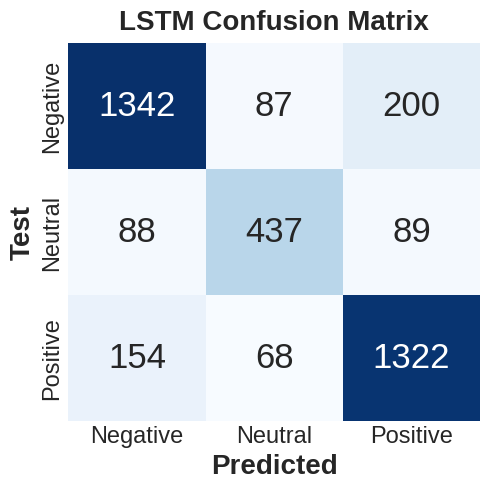

In [ ]:
# prompt: Create LSTM model
Tokenizer = tf.keras.preprocessing.text.Tokenizer
pad_sequences = tf.keras.preprocessing.sequence.pad_sequences

# Function to create the LSTM model
def create_lstm_model(vocab_size, max_length):
  model = keras.Sequential([
      keras.layers.Embedding(vocab_size, 128, input_length=max_length),
      keras.layers.LSTM(128),
      keras.layers.Dense(3, activation='softmax')
  ])
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

# Tokenize the text data
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
print('Vocabulary size:', vocab_size)

# Pad the sequences
max_length = max([len(x.split()) for x in X_train])
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_valid_seq = tokenizer.texts_to_sequences(X_valid)
X_valid_pad = pad_sequences(X_valid_seq, maxlen=max_length, padding='post')
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

# Create the LSTM model
model_lstm = create_lstm_model(vocab_size, max_length)

# Train the model
history = model_lstm.fit(X_train_pad, y_train, epochs=10, validation_data=(X_valid_pad, y_valid))

# Evaluate the model
loss, accuracy = model_lstm.evaluate(X_test_pad, y_test)
print('Loss:', loss)
print('Accuracy:', accuracy)

# Make predictions
y_pred = model_lstm.predict(X_test_pad)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Print classification report
print(classification_report(y_test_classes, y_pred_classes))

# Plot confusion matrix
conf_matrix(y_test_classes, y_pred_classes, 'LSTM Confusion Matrix')


In [ ]:
model_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 64, 128)           6226816   
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dense_2 (Dense)             (None, 3)                 387       
                                                                 
Total params: 6358787 (24.26 MB)
Trainable params: 6358787 (24.26 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


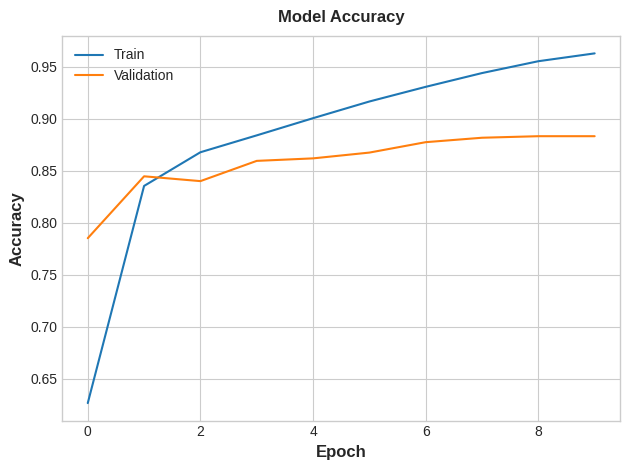

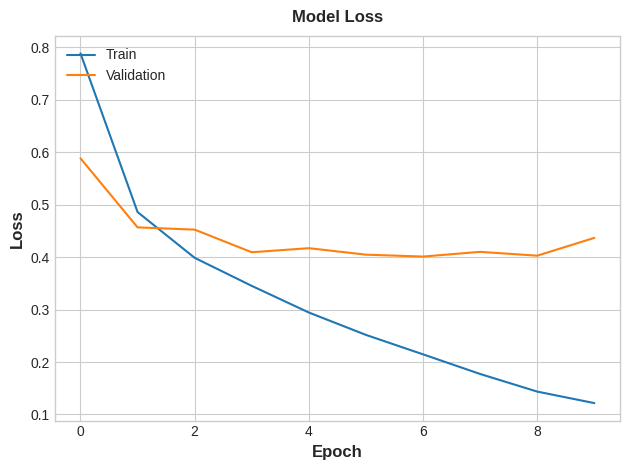

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

# Now you can call the function:
plot_history(h)

# Save the model in pickle
import pickle
with open('model_sentiment_analysis.pkl', 'wb') as f:
    pickle.dump(model_lstm, f)

with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def create_lstm_model(vocab_size, max_length):
    model = keras.Sequential([
        keras.layers.Embedding(vocab_size, 128, input_length=max_length),
        keras.layers.LSTM(128),
        keras.layers.Dense(3, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
print('Vocabulary size:', vocab_size)

max_length = max([len(x.split()) for x in X_train])
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_valid_seq = tokenizer.texts_to_sequences(X_valid)
X_valid_pad = pad_sequences(X_valid_seq, maxlen=max_length, padding='post')
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post')


model_lstm = create_lstm_model(vocab_size, max_length)

history = model_lstm.fit(X_train_pad, y_train, epochs=10, validation_data=(X_valid_pad, y_valid))

loss, accuracy = model_lstm.evaluate(X_test_pad, y_test)
print('Loss:', loss)
print('Accuracy:', accuracy)


Vocabulary size: 48647
Epoch 1/10
1519/1519 [==============================] - 438s 286ms/step - loss: 1.0774 - accuracy: 0.3642 - val_loss: 1.0988 - val_accuracy: 0.3333
Epoch 2/10
1519/1519 [==============================] - 365s 240ms/step - loss: 0.8976 - accuracy: 0.5053 - val_loss: 0.6125 - val_accuracy: 0.7806
Epoch 3/10
1183/1519 [======================>.......] - ETA: 1:13 - loss: 0.4811 - accuracy: 0.8356

KeyboardInterrupt: 

In [ ]:
import pickle

# Save tokenizer
with open('tokenizer_1.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

# Save model
with open('model_lstm_1.pkl', 'wb') as f:
    pickle.dump(model_lstm, f)

## BERT Sentiment Analysis

In [ ]:
!pip install transformers

In [ ]:
MAX_LEN = 128
def tokenize(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [ ]:
train_input_ids, train_attention_masks = tokenize(X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize(X_valid, MAX_LEN)
test_input_ids, test_attention_masks = tokenize(X_test, MAX_LEN)

AttributeError: 'Tokenizer' object has no attribute 'encode_plus'

In [ ]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
#he classification of the 3 different classes of the dataset (the 3 emotions).

def create_model(bert_model, max_len=MAX_LEN):

    ##params###
    # Use 'learning_rate_decay' instead of 'decay'
    opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()


    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')

    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')

    embeddings = bert_model([input_ids,attention_masks])[1]

    output = tf.keras.layers.Dense(3, activation="softmax")(embeddings)

    model = tf.keras.models.Model(inputs = [input_ids,attention_masks], outputs = output)

    model.compile(opt, loss=loss, metrics=accuracy)

    # Return the model (you had a typo here)
    return model

model_bert = create_model(bert_model, MAX_LEN)
model_bert.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_1[0][0]',             
 )                           ngAndCrossAttentions(last_   40         'input_2[0][0]']             
                             hidden_state=(None, 128, 7                                           
                             68),                                                             

In [ ]:
# y_train = tf.keras.utils.to_categorical(original_y_train, num_classes=3)

history_bert = model_bert.fit([train_input_ids,train_attention_masks], y_train[:len(train_input_ids)],
                         validation_data=([val_input_ids,val_attention_masks], y_valid[:len(val_input_ids)]), # Also slice y_valid for consistency
                         epochs=4, batch_size=32)

Epoch 1/4
1515/1519 [============================>.] - ETA: 3:27 - loss: 0.5508 - categorical_accuracy: 0.7805

In [ ]:
# Save bert model
import pickle

model_bert.save('model_bert.pkl')

In [ ]:
# BERT Results
result_bert = model_bert.predict([test_input_ids,test_attention_masks])
y_pred_bert =  np.zeros_like(result_bert)
y_pred_bert[np.arange(len(y_pred_bert)), result_bert.argmax(1)] = 1
conf_matrix(y_test.argmax(1), y_pred_bert.argmax(1),'BERT Sentiment Analysis\nConfusion Matrix')

In [ ]:
print('\tClassification Report for BERT:\n\n',classification_report(y_test,y_pred_bert, target_names=['Negative', 'Neutral', 'Positive']))

## RoBERTa Sentiment Analysis

In [ ]:
# Import tokenizer used to train the original roberta transformer by facebook
tokenizer_roberta = RobertaTokenizerFast.from_pretrained("roberta-base")

In [ ]:
# The length of the longest tokenized sentence by roberta tokenizer
token_lens = []

for txt in X_train:
    tokens = tokenizer_roberta.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
max_length=np.max(token_lens)
max_length


In [ ]:
MAX_LEN = 128
def tokenize_roberta(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer_roberta.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [ ]:
train_input_ids, train_attention_masks = tokenize_roberta(X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize_roberta(X_valid, MAX_LEN)
test_input_ids, test_attention_masks = tokenize_roberta(X_test, MAX_LEN)

In [ ]:
def create_model(bert_model, max_len=MAX_LEN):

    opt = tf.keras.optimizers.Adam(learning_rate=1e-5, decay=1e-7)
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()

    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')
    output = bert_model([input_ids,attention_masks])
    output = output[1]
    output = tf.keras.layers.Dense(3, activation=tf.nn.softmax)(output)
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(opt, loss=loss, metrics=accuracy)
    return model

roberta_model = TFRobertaModel.from_pretrained('roberta-base')
model_roberta = create_model(roberta_model, MAX_LEN)
model_roberta.summary()

In [ ]:
history_2 = model.fit([train_input_ids,train_attention_masks], y_train, validation_data=([val_input_ids,val_attention_masks], y_valid), epochs=4, batch_size=30)

In [ ]:
result_roberta = model.predict([test_input_ids,test_attention_masks])

In [ ]:
y_pred_roberta =  np.zeros_like(result_roberta)
y_pred_roberta[np.arange(len(y_pred_roberta)), result_roberta.argmax(1)] = 1

In [ ]:
print('\tClassification Report for RoBERTa:\n\n',classification_report(y_test,y_pred_roberta, target_names=['Negative', 'Neutral', 'Positive']))

In [ ]:
print('Classification Report for BERT:\n',classification_report(y_test,y_pred_bert, target_names=['Negative', 'Neutral', 'Positive']))

In [ ]:
print('Classification Report for RoBERTa:\n',classification_report(y_test,y_pred_roberta, target_names=['Negative', 'Neutral', 'Positive']))

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(9,5.5))

labels = ['Negative', 'Neutral', 'Positive']
plt.suptitle('Sentiment Analysis Comparison\n Confusion Matrix', fontsize=20)


sns.heatmap(confusion_matrix(y_test.argmax(1),y_pred_bert.argmax(1)), annot=True, cmap="Blues", fmt='g', cbar=False, ax=ax[0], annot_kws={"size":25})

ax[0].set_title('BERT Classifier', fontsize=20)
ax[0].set_yticklabels(labels, fontsize=17);
ax[0].set_xticklabels(labels, fontsize=17);
ax[0].set_ylabel('Test', fontsize=20)
ax[0].set_xlabel('Predicted', fontsize=20)

sns.heatmap(confusion_matrix(y_test.argmax(1),y_pred_roberta.argmax(1)), annot=True, cmap="Blues", fmt='g', cbar=False, ax=ax[1], annot_kws={"size":25})
ax[1].set_title('RoBERTa Classifier', fontsize=20)
ax[1].set_yticklabels(labels, fontsize=17);
ax[1].set_xticklabels(labels, fontsize=17);
ax[1].set_ylabel('Test', fontsize=20)
ax[1].set_xlabel('Predicted', fontsize=20)


plt.show()

In [ ]:
import numpy as np
import pickle
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_length = 512

# Define a function to preprocess text data
def preprocess_text(texts, tokenizer, max_length):
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')
    return padded_sequences

# Define a function to get user input and make predictions
def predict_user_input():
    # Load the saved model
    with open('/content/model_lstm_1.pkl', 'rb') as file:
        tokenizer = pickle.load(file)

    # Load the saved tokenizer
    with open('/content/tokenizer_1.pkl', 'rb') as file:
        tokenizer = pickle.load(file)

    # Get the correct max_length from the tokenizer
    max_length = tokenizer.num_words # Use the vocabulary size as max_length

    # Get input from user
    user_input = input("Enter the text you want to classify: ")
    new_texts = [user_input]

    # Preprocess new data
    new_data_pad = preprocess_text(new_texts, tokenizer, max_length)

    # Make predictions
    predictions = model_lstm.predict(new_data_pad)

    # Convert predictions to class labels
    predicted_classes = np.argmax(predictions, axis=1)

    # Define class labels (ensure this matches your model's output classes)
    class_labels = ['Class A', 'Class B', 'Class C']  # Adjust as needed
    predicted_class_names = [class_labels[i] for i in predicted_classes]

    # Print the result
    print(f"The input text is classified as: {predicted_class_names[0]}")

# Run the function
predict_user_input()

Enter the text you want to classify: Find out how you can protect yourself and loved ones from #coronavirus. ?


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py", line 2436, in predict_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py", line 2421, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py", line 2409, in run_step  **
        outputs = model.predict_step(data)
    File "/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py", line 2377, in predict_step
        return self(x, training=False)
    File "/usr/local/lib/python3.10/dist-packages/tf_keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_3" is incompatible with the layer: expected shape=(None, 64), found shape=(None, 5000)
